## Introduction

In this notebook (forked  from burn1.ipynb), we perform various experiments to refine the burn model and hyperparameters. We use the dataset :  burn_nosplit_final, and initially train on ResNet34 with mixup. We then train the model for varying dropout rates and batch sizes while also observing accuract vs learning rate curve. We plot the top losses to understand the incorrectly classified classes and suggest to add more 'none' type images that resemble 1/2/3 classes in the 'none' set. We also observe that some training results yield unusual >95% accuracy resulting from data leakage in train/valid set such as duplicates. 


In summary: optimal values of hyperparameters
- bs = 128 or 224 
- ps = 0.2 
- lr = slice(1e-3,1e-2), lr_max= 0.1
- top losses from 1/2, 2/3, and mostly (1-3)/none classes
- arch = ResNet50



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import sys
import importlib.util
from pathlib import Path
from google.colab import drive
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import numpy as np

In [5]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
sys.path.append('/content/gdrive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
path = Path('/content/drive/My Drive/burn/burn_nosplit_final')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/models')]

## Training and Predictions : ResNet34 with mixup




### No dropout (ps=0)


In [7]:
path = Path('/content/drive/My Drive/burn/burn_nosplit_final')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/models')]

In [0]:
tfms = get_transforms(flip_vert=True)
np.random.seed(0)
data1 = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=64).normalize(imagenet_stats)

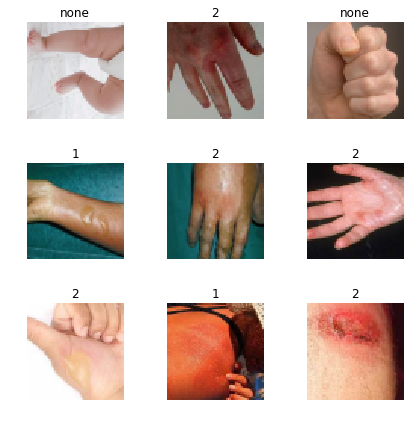

In [16]:
data1.show_batch(rows=3, figsize=(6, 6))

In [17]:
print(data1.classes)

['1', '2', '3', 'none']


In [0]:
learn_1 = cnn_learner(data1, models.resnet34, metrics=accuracy, ps=0).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


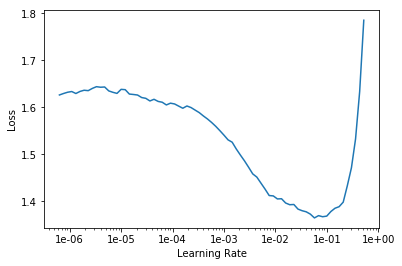

In [20]:
learn_1.lr_find()
learn_1.recorder.plot()

In [0]:
learn_1.fit_one_cycle(100, slice(1e-3,1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

In [22]:
accuracy(*learn_1.get_preds())

tensor(0.7748)

In [0]:
learn_1.save('burn_nosplit_ps0')

### Dropout tests (ps = 0.0 to 0.9)  

In [0]:
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
acc = []   #accuracy array
# acc_ps = []   #accuracy array for ps

#loop through all entries in the dropouts array, bs = 64
for dropout in dropouts:
    learn = cnn_learner(data1, models.resnet34, metrics=accuracy, ps=dropout).mixup()
    
    print('Dropout Rate:',dropout)
    %time 
    fit_array = learn.fit_one_cycle(20, slice(1e-3,1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

    acc.append( accuracy(*learn.get_preds()) )

    
#  Buffered data was truncated after reaching the output size limit on ps=0.3 - for 100 epochs, so try 20
# [0.0, 0.1, 0.2, 0.3]
# [tensor(0.7432), tensor(0.7387), tensor(0.7568), tensor(0.7703)]

In [0]:
learn.save('burn_nosplit_ps')

### Plot of Dropout results

In [30]:
print(dropouts)
print(acc)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[tensor(0.7117), tensor(0.7117), tensor(0.7477), tensor(0.7387), tensor(0.7477), tensor(0.7252), tensor(0.6757), tensor(0.6577), tensor(0.7117), tensor(0.7027)]


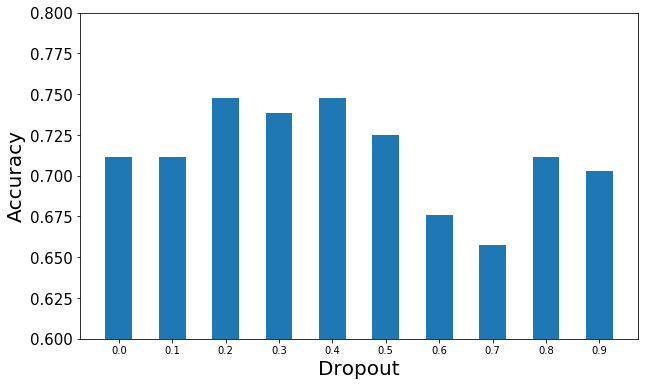

In [31]:
width = 0.05 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(dropouts, acc, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=15)

xrange = np.arange(0,1,.1)
plt.xticks(xrange, dropouts)
plt.ylim(.6,.8, .1)

plt.xlabel('Dropout', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()

- Dropout of 0.2 or 0.4 seem optimal.

### Varying Batch Size

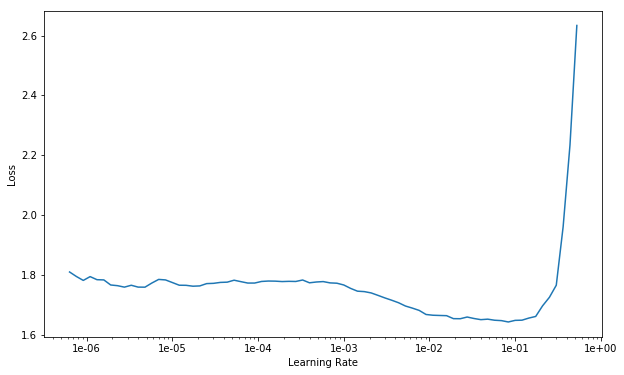

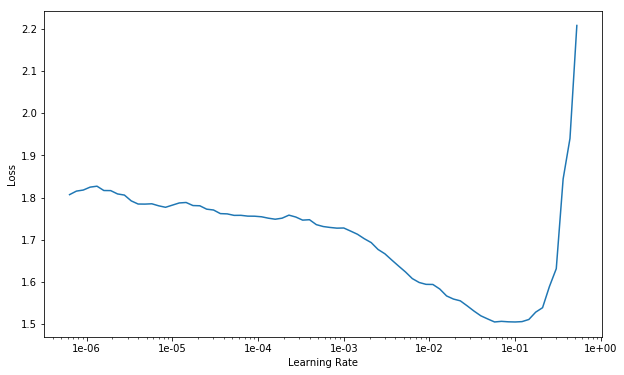

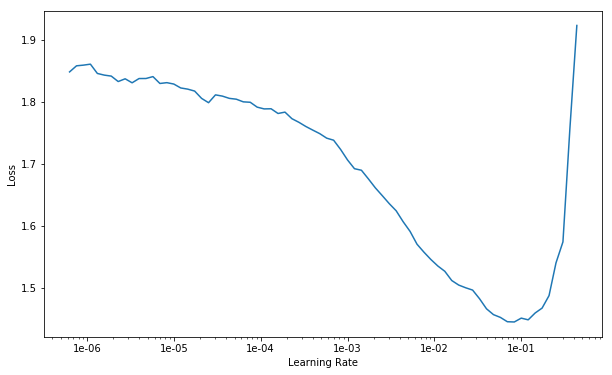

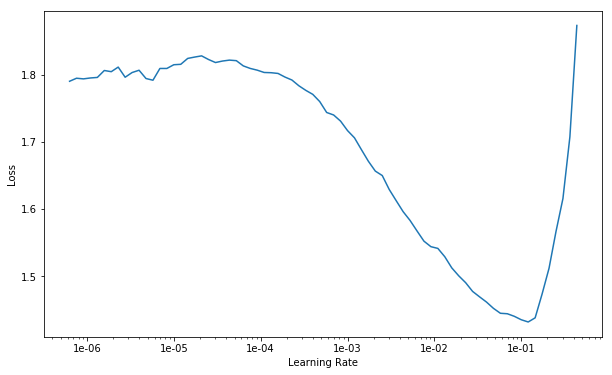

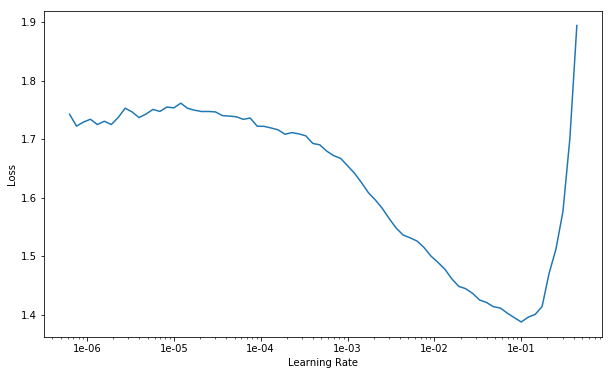

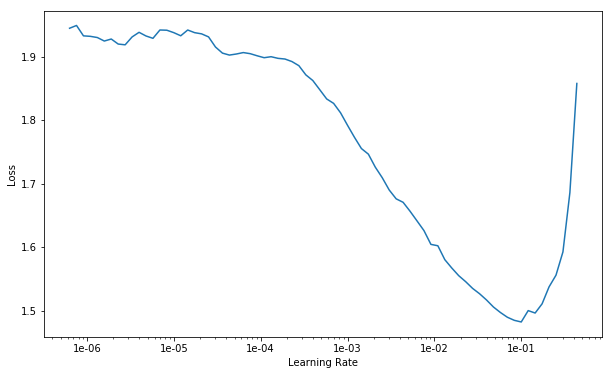

In [35]:
tfms = get_transforms(flip_vert=True)
batchsize = [32, 64, 128, 224, 256, 512]
acc_bs = []   #accuracy array for bs


for bs in batchsize: 
    np.random.seed(0)
    data = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=bs).normalize(imagenet_stats) 

    learn = cnn_learner(data, models.resnet34, metrics=accuracy).mixup()  #ps = 0.5 default

#     learn.lr_find()
#     learn.recorder.plot()

    print('Batch Size:', bs)
    %time 
    fit_array = learn.fit_one_cycle(20, slice(1e-3,1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

    acc_bs.append( accuracy(*learn.get_preds()) )

Note: Learning rate lr = slice(1e-3,51e-2) or  lr_max = 0.1 (seem optimal). 

In [0]:
# learn.save('burn_nosplit_final_bs')


In [38]:
print(batchsize)
print(acc_bs)

[32, 64, 128, 224, 256, 512]
[tensor(0.6036), tensor(0.7162), tensor(0.7928), tensor(0.7928), tensor(0.7568), tensor(0.7748)]


### Plot of varying batch size results

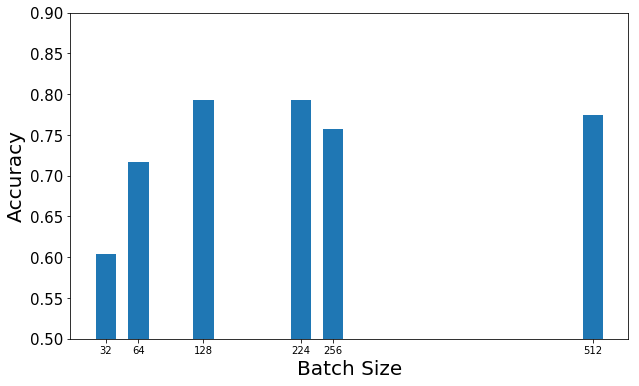

In [63]:
width = 20 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(batchsize, acc_bs, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=15)

xrange = np.arange(16, 528, 64)
plt.xticks(batchsize)
plt.ylim(.5,.9)

plt.xlabel('Batch Size', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()

In [0]:
# bs = 128 or 224 seems optimal. Choose 224 as some torch models require minimum bs=224.

## Top Losses

-  for  the initial run with bs = 64,  ps = 0.5 

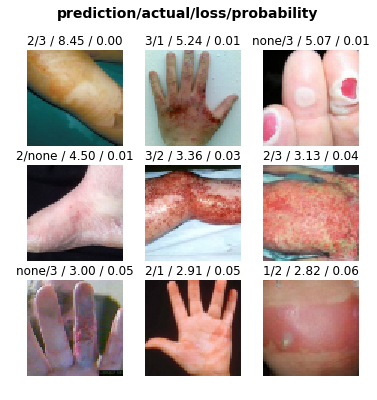

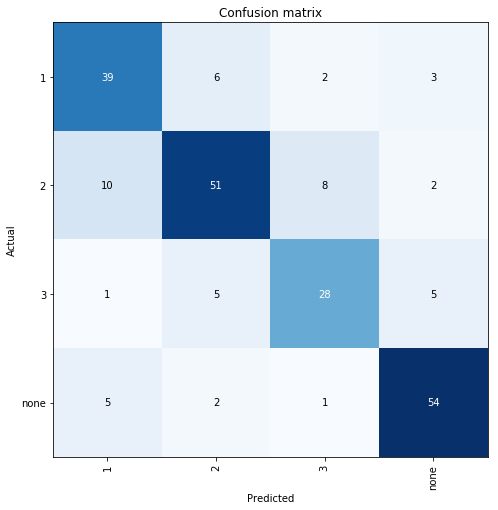

In [65]:
interp = ClassificationInterpretation.from_learner(learn_1)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))



Note: Most inaccurately classified images are on the off-diagonal of the confusion matrix between 1/2 , 2/3 and (1-3)/none.  Adding especially more 'none' type dataset is necessary to increase classification accuracy.

# Model Architectures: ResNet, DenseNet  etc

- next steps

In [0]:
#different architectures 

import torchvision.models as models

#2015-2017
resnet18 = models.resnet18 #(pretrained=True) #(error)
resnet34 = models.resnet34 #(pretrained=True)
resnet50 = models.resnet50 #(pretrained=True)
resnet101 = models.resnet101 #(pretrained=True)
resnet152 = models.resnet152 #(pretrained=True)

#other 2012-2014
alexnet = models.alexnet #(pretrained=True)
squeezenet1_1 = models.squeezenet1_0 #(pretrained=True)
vgg19 = models.vgg19 #(pretrained=True)
densenet161 = models.densenet161 #(pretrained=True)
inception = models.inception_v3 #(pretrained=True)
# googlenet = models.googlenet(pretrained=True) #inception_v1

#2017
# shufflenet = models.shufflenetv2(pretrained=True)


# Also check from fastai.vision.models
# Darknet
# WideResNet
# unet - for segmentation


#10 model architectures
all_models = [resnet18, resnet34, resnet50 , resnet101, resnet152,
              alexnet, squeezenet1_1, vgg19 , densenet161 ,inception]


acc_nn = []   #accuracy array for each nn 

np.random.seed(0)
tfms = get_transforms(flip_vert=True)
data = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=224).normalize(imagenet_stats) 

for arch in all_models: 

    learn = cnn_learner(data, resnet18 , metrics=accuracy).mixup()  #ps = 0.5 default

    #     learn.lr_find()
    #     learn.recorder.plot()

    print('Model', arch)
    %time 
    fit_array = learn.fit_one_cycle(20, slice(1e-3,1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1')])

    acc_nn.append( accuracy(*learn.get_preds()) )
 

In [85]:
print(all_models)
print(acc_nn)

[<function resnet18 at 0x7f551b436598>, <function resnet34 at 0x7f551b4369d8>, <function resnet50 at 0x7f551b436a60>, <function resnet101 at 0x7f551b436ae8>, <function resnet152 at 0x7f551b436b70>, <function alexnet at 0x7f551b436268>, <function squeezenet1_0 at 0x7f551b3c22f0>, <function vgg19 at 0x7f551b3c21e0>, <function densenet161 at 0x7f551b3cf8c8>, <function inception_v3 at 0x7f551b3c27b8>]
[tensor(0.7477), tensor(0.7703), tensor(0.7883), tensor(0.7568), tensor(0.7658), tensor(0.7252), tensor(0.7613), tensor(0.7658), tensor(0.7207), tensor(0.7523)]


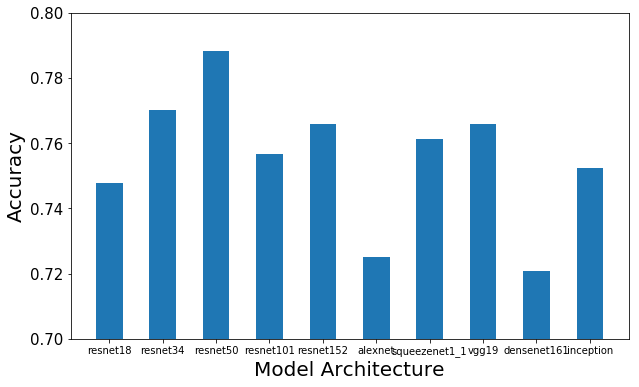

In [92]:
all_models_names = ['resnet18', 'resnet34', 'resnet50' , 'resnet101', 'resnet152',
              'alexnet', 'squeezenet1_1', 'vgg19' , 'densenet161' ,'inception']

width = 0.5 # bar width
# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set new size (0=width,1=height)
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.bar(all_models_names, acc_nn, width, align='center')

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=15)

# xrange = np.arange(0,1,.1)
plt.xticks(all_models_names )
plt.ylim(.7,.8, .05)

plt.xlabel('Model Architecture', size = 20)
plt.ylabel('Accuracy',size = 20)

plt.show()

Note: ResNet50 has the highest accuracy among the architectures considerd.



(Solomon,A)
